In [2]:
from quippy.descriptors import Descriptor
from ase.io import read
from xml.etree.ElementTree import parse
import os
import numpy as np
import scipy
from ase.data import chemical_symbols
import re

Z_regex = "(Z|z)[1-9]*\s?=\s?([1-9]+)" # RegEx to search command line for "Z=, Z1 = or z2= style args"
Z_regex = re.compile(Z_regex)

# Main method to calculate cov kernel from cov type flag
def cov_kernel(cov_type, xs, x_cuts, ys, y_cuts, cov_prop, delta):
  '''
  Generate covariance kernel matrix for several kinds of similarity function
  
  cov_type : int
    Key giving kind of similarity function to use. 1:ard_se, 2:dot_product
  
  xs: numpy.ndarray
    X values
  
  '''
  nx = len(x_cuts)
  ny = len(y_cuts)

  if cov_type == 1: # ard_se
      theta = cov_prop

      K = _ard_se(theta, xs, ys, nx, ny)

  elif cov_type == 2: # dot_product
    zeta = cov_prop[0]

    K = _dot_product(xs, ys, nx, ny) ** zeta

  K *= delta**2
  return K

# Covariance Kernels
def _ard_se(theta, xs, ys, nx, ny):
  K = np.zeros((nx, ny))

  for i in range(nx):
    K[i, :] = np.exp(-0.5 * (xs[i, ...] - ys)**2 / theta**2)[:, 0]
  return K

def _dot_product(xs, ys, nx, ny):
  K = np.zeros((nx, ny))

  for i in range(nx):
    K[i, :] = xs[i, ...] @ ys.T
  return K


# Python implementation of the GAP model
class GapReader():
  # Initialise GAP model
  def __init__(self, gp_dir, gp_file, sigma):

    self.sigma = sigma
    
    self.fname = gp_dir + os.sep + gp_file
    
    # Open XML file
    tree = parse(self.fname)
    self.gp_xml = tree.getroot()

    # GP Label
    self.gp_label = self.gp_xml[0].attrib["label"]

    # Grab descriptor branches
    self.all_desc = self.gp_xml[1][1][:]

    # Isolated atom energies
    isolated_energies = self.gp_xml[1][0][:]
    self.isolated_energies = {}
    for at_type in isolated_energies:
      self.isolated_energies[int(at_type.attrib["Z"])] = float(at_type.attrib["value"])
      
    self.num_desc = len(self.all_desc)

    # Space to dump descriptor params
    self.descs = []
    self.desc_types = []
    self.desc_cmds = []
    self.desc_names = []
    self.nsparses = []
    self.alphas = []
    self.cuts = []
    self.cov_types = []
    self.cov_props = []
    self.deltas = []

    # Grab details for each descriptor
    for desc in self.all_desc:
      descriptor = [child for child in desc if "descriptor" in child.tag]

      alphas = np.array([float(child.attrib["alpha"]) for child in desc if "sparseX" in child.tag])
      cuts = np.array([float(child.attrib["sparseCutoff"]) for child in desc if "sparseX" in child.tag])
      delta = float(desc.attrib["signal_variance"])
      cov_type = int(desc.attrib["covariance_type"])

      cmd = descriptor[0].text

      if cov_type == 1: # ard_se
        cov_prop = float([child.text for child in desc if "theta" in child.tag][0])
      elif cov_type == 2: # dot_product
        cov_prop = float(desc.attrib["zeta"])
      else:
        print(f"Cov type {cov_type} not understood")
        cov_prop = 0

      
      desc_type = cmd.split(" ")[0]
      
      # Find chemical species the descriptor acts on
      Zs = Z_regex.findall(cmd)
      desc_Zs = [Z[1] for Z in Zs]


      # Generate a helpful name for the descriptor
      desc_name = "".join([chemical_symbols[int(Z)] for Z in desc_Zs]) + " " + desc_type

      self.descs.append(Descriptor(descriptor[0].text))
      self.desc_cmds.append(cmd)
      self.desc_types.append(desc_type)
      self.desc_names.append(desc_name)
      self.nsparses.append(len(alphas))
      self.alphas.append(alphas)
      self.cuts.append(cuts)
      self.cov_types.append(cov_type)
      self.cov_props.append(cov_prop)
      self.deltas.append(delta)

    # Load sparse points for each descriptor from .sparseX files
    self.sparse_files = sorted([file for file in os.listdir(gp_dir) if gp_file in file and "sparseX" in file and self.gp_label in file])

    self.sparseXs = [np.loadtxt(gp_dir + os.sep + file).reshape((self.nsparses[i], -1)) for i, file in enumerate(self.sparse_files)]

    # Generate sparseX-sparseX covariance Kernels (K_xx) & Cholesky decomps
    self.Ks = []
    self.Ls = []

    for i in range(self.num_desc):
      cov_type = self.cov_types[i]
      cov_prop = self.cov_props[i]

      delta = self.deltas[i]

      sparseX = self.sparseXs[i]
      cuts = self.cuts[i]

      K = cov_kernel(cov_type, sparseX, cuts, sparseX, cuts, cov_prop, delta)
      K += self.sigma**2 * np.eye(K.shape[0])

      self.Ks.append(K)

      L = np.linalg.cholesky(K)
      self.Ls.append(L)

def predict_energy(self, atoms):
    '''
    Predict total energy posterior mean and variance
    '''

    # Account for isolated atom energies
    E_tot = sum([self.isolated_energies[Z] for Z in atoms.get_atomic_numbers()])
    E_var = 0

    # Loop over each descriptor 
    for i, desc in enumerate(self.descs):
      # Get kind of cov kernel (dot_product, ard_se, ...)
      cov_type = self.cov_types[i]
      # Get kernel hyperparameters (theta, xi, ...)
      cov_prop = self.cov_props[i]

      # Energy scaling factor for descriptor
      delta = self.deltas[i]

      # Weights
      alphas = self.alphas[i]

      # Apply descriptor to model
      result = desc.calc(atoms, grad=True)

      # Descriptor vectors found in structure
      x_star = result["data"]
      x_star_cut = result["covariance_cutoff"]

      x = self.sparseXs[i]
      x_cut = self.cuts[i]

      # Generate all cov matrices
      L = self.Ls[i] # Cholesky decomp of (K_x_x + Sigma)
      
      # Construct all useful matrices
      K_xstar_x = cov_kernel(cov_type, x_star, x_star_cut, x, x_cut, cov_prop, delta)

      K_x_xstar = K_xstar_x.T

      K_xstar_xstar = cov_kernel(cov_type, x_star, x_star_cut, x_star, x_star_cut, cov_prop, delta)

      # Energy prediction
      # sol computes [K_x_x + Sigma]^-1 via Cholesky decomp
      sol = scipy.linalg.solve_triangular(L, K_x_xstar, lower=True).T
      
      E_desc = K_xstar_x @ alphas
      var_desc = K_xstar_xstar - sol @ sol.T
      
      E_tot += np.sum(E_desc)
      E_var += np.sum(var_desc)

    return E_tot, E_var

ModuleNotFoundError: No module named 'quippy.descriptors'

In [ ]:
# Read in structures
from ase.io import read

reference = read("InP_Bulk.xyz")
nats = len(reference)

defect = read("Structs/I_P.xyz")

FileNotFoundError: [Errno 2] No such file or directory: 'Structs/reference.xyz'

In [ ]:
# Initialise GAP model

gap = GapReader("GAP", "InP_GAP.xml", sigma=0.0001)

E_ref, var_ref = gap.predict_energy(reference)

E_defect, var_defect = gap.predict_energy(defect)

NameError: name 'GapReader' is not defined

In [ ]:
from scipy.stats import norm

ref_dist = norm(loc=E_ref, scale=var_ref)

defect_dist = norm(loc=E_defect, scale=var_defect)


nsamples = 100

# Draw samples of the defect formation energy
E_formations = defect_dist.rvs(nsamples) * (nats)/(nats+1) - ref_dist.rvs(nsamples)

NameError: name 'E_ref' is not defined

NameError: name 'nsamples' is not defined

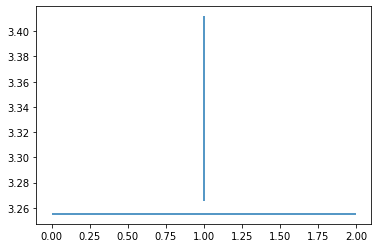

In [ ]:
import matplotlib.pyplot as plt

E_dft = 3.2551966973845765

E_gap = 3.338686329162499078e+00
var_gap = 7.319755644693674845e-02


plt.hlines(E_dft, 0, 2)

plt.errorbar(1, E_gap, yerr=var_gap)

plt.scatter([2]*nsamples, E_formations, marker="x", alpha=0.4)

plt.show()